# Object Detection

Welcome to the final week! Here we will be looking at a notebok by Christian Marzahl, where we have a working example for doing **Object Detection** in Fast.AI

In [0]:
!git clone https://github.com/ChristianMarzahl/ObjectDetection.git

In [0]:
!git clone https://github.com/rafaelpadilla/Object-Detection-Metrics.git

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [0]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [0]:
from helper.object_detection_helper import *
from loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from models.RetinaNet import RetinaNet

In [19]:
%cd Object-Detection-Metrics/lib

/content/Object-Detection-Metrics/lib


In [0]:
from callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

In [0]:
coco = untar_data(URLs.COCO_SAMPLE)
images, lbl_bbox = get_annotations(coco/'annotations/train_sample.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [22]:
coco

PosixPath('/root/.fastai/data/coco_sample')

In [0]:
size = 256

In [0]:
data = (ObjectItemList.from_folder(coco)
        #Where are the images? -> in coco
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), tfm_y=True, size=size)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=64, collate_fn=bb_pad_collate))
        #Finally we convert to a DataBunch and we use bb_pad_collate
#data = data.normalize()

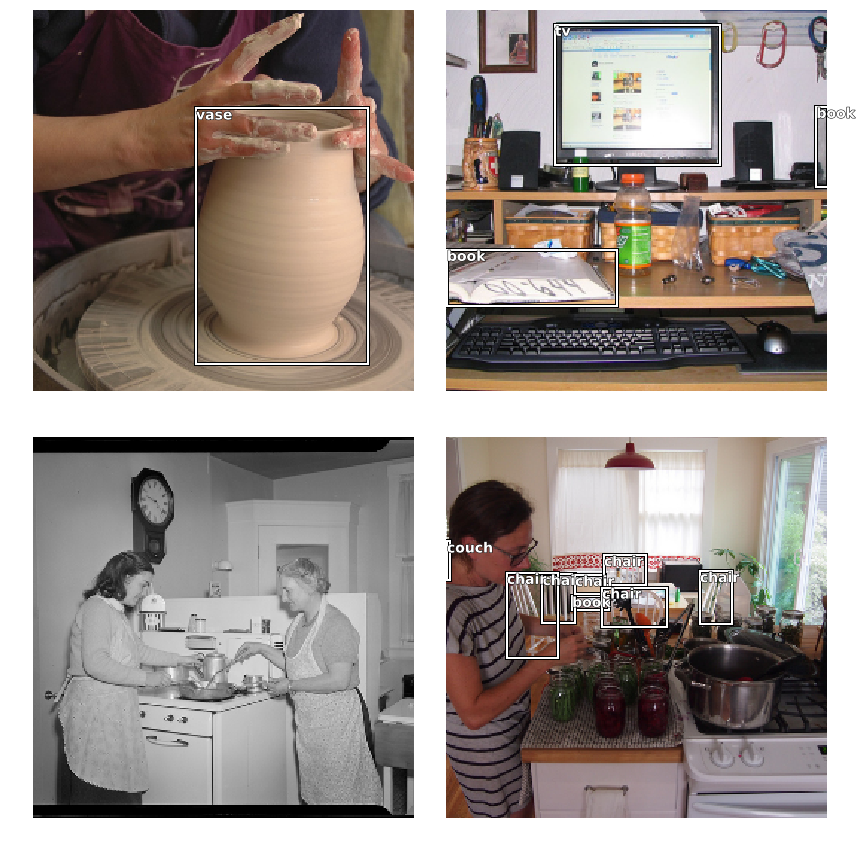

In [26]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(12,12))

In [27]:
data.classes

['background', 'book', 'chair', 'couch', 'remote', 'tv', 'vase']

In [28]:
[1,2**(1/3), 2**(2/3)]

[1, 1.2599210498948732, 1.5874010519681994]

In [0]:
anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4)], ratios=[0.5, 1, 2], scales=[0.35, 0.5, 0.6, 1, 1.25, 1.6])

In [30]:
len(anchors)

24480

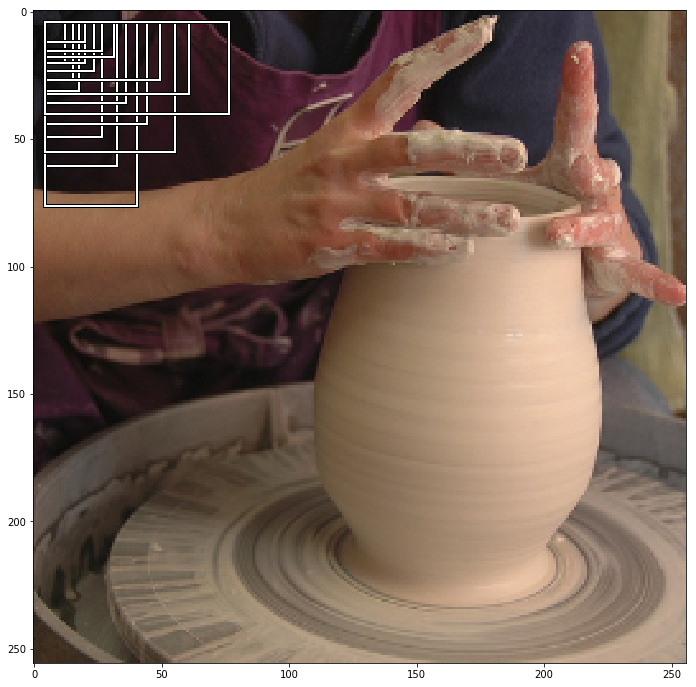

In [33]:
fig,ax = plt.subplots(figsize=(12,12))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:18]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size / 2 
    y = (bb[1] + 1) * size / 2 
    w = bb[2] * size / 2
    h = bb[3] * size / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

In [35]:
all_boxes, all_labels = show_anchors_on_images(data, anchors, figsize=(12,12))

Output hidden; open in https://colab.research.google.com to view.

In [36]:
data.train_ds.c

7

In [37]:
n_classes = data.train_ds.c

crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=18, sizes=[32,16,8,4], chs=32, final_bias=-4., n_conv=2)
#model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 48501749.82it/s]


In [38]:
model

RetinaNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [0]:
voc = PascalVOCMetric(anchors, size, [i for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[ShowGraph, BBMetrics],
                metrics=[voc])

In [0]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-04
Min loss divided by 10: 4.37E-04


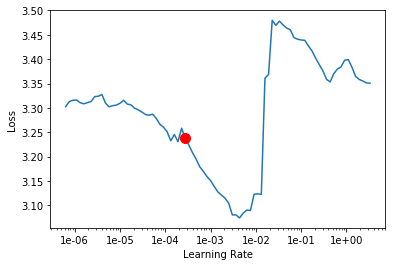

In [41]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

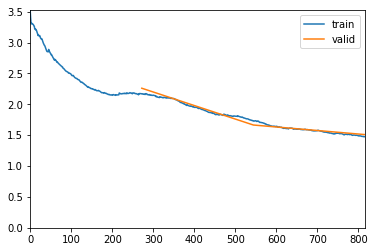

In [0]:
learn.fit_one_cycle(3, 1e-3)

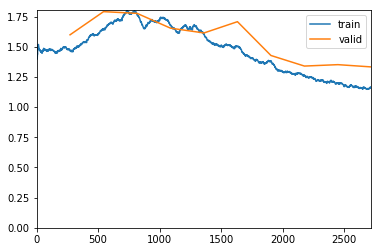

In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

In [0]:
data.train_ds.classes

['background', 'book', 'chair', 'couch', 'remote', 'tv', 'vase']

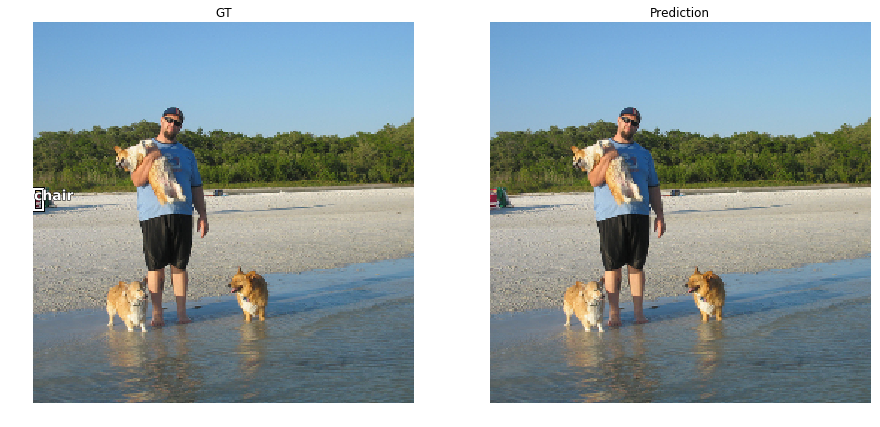

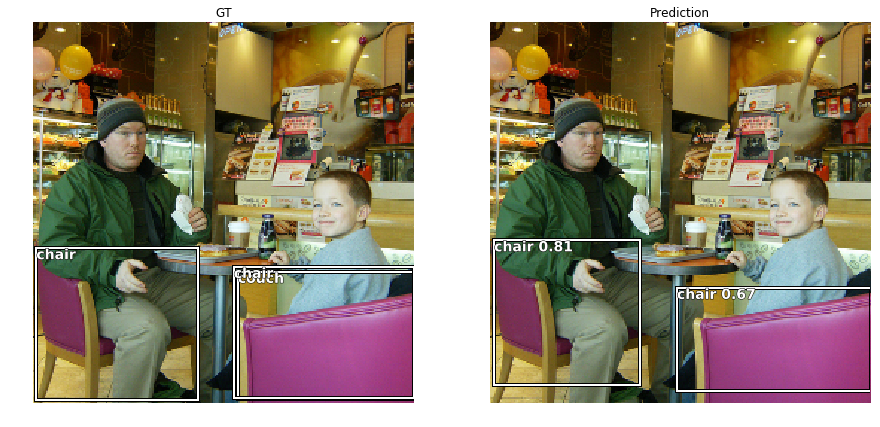

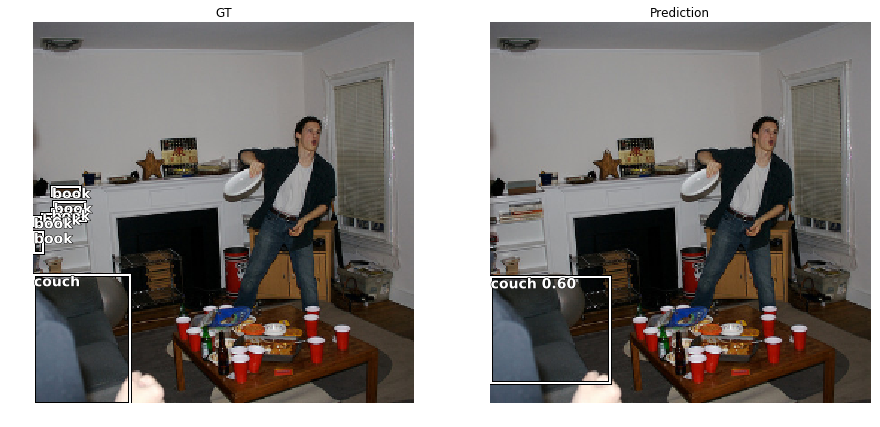

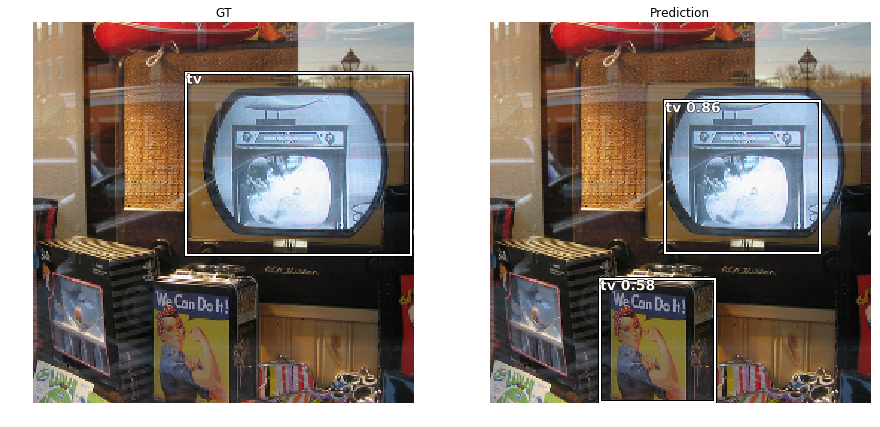

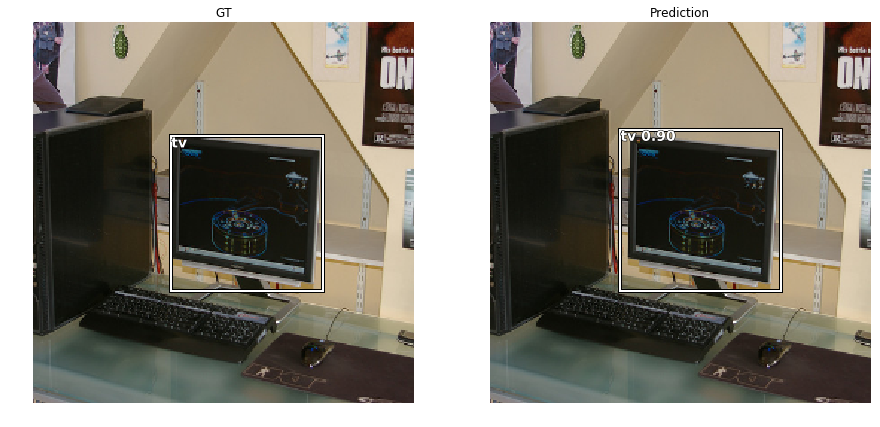

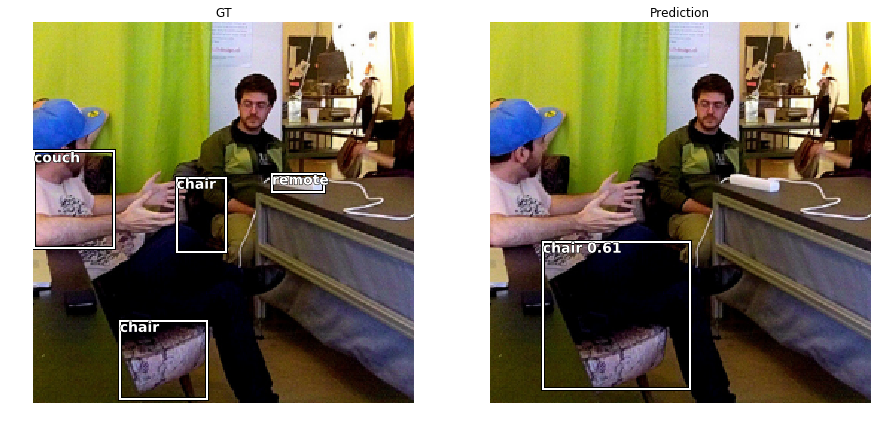

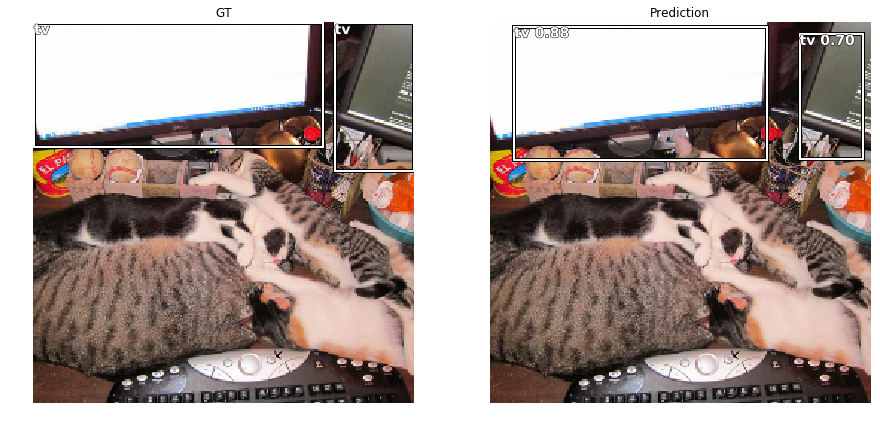

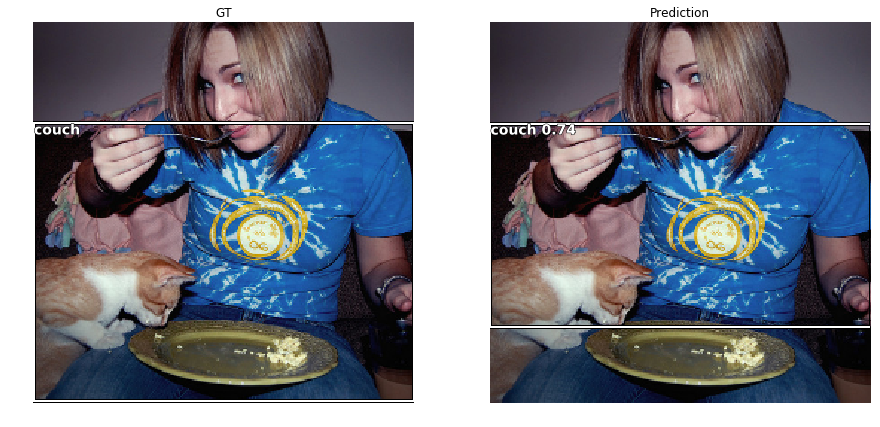

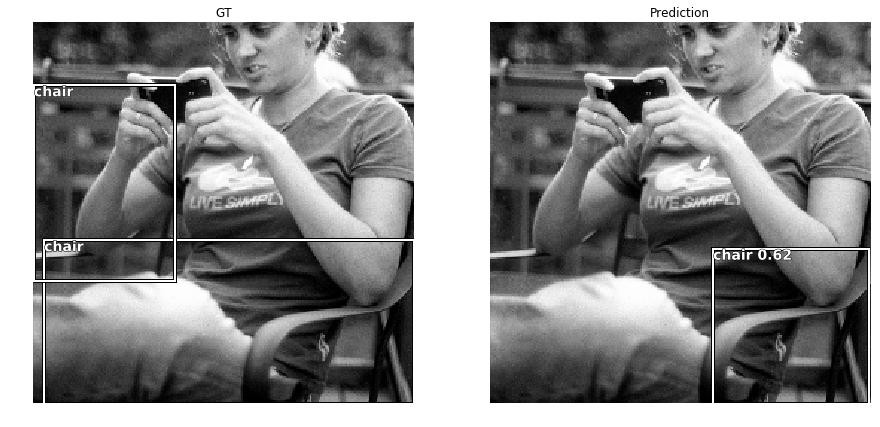

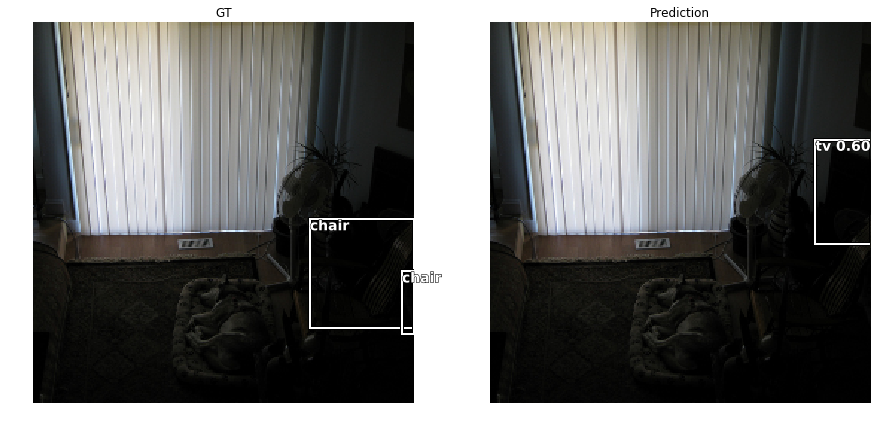

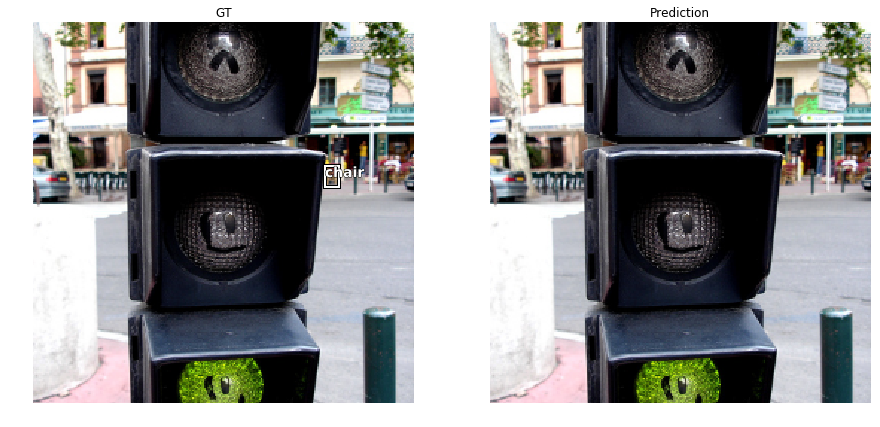

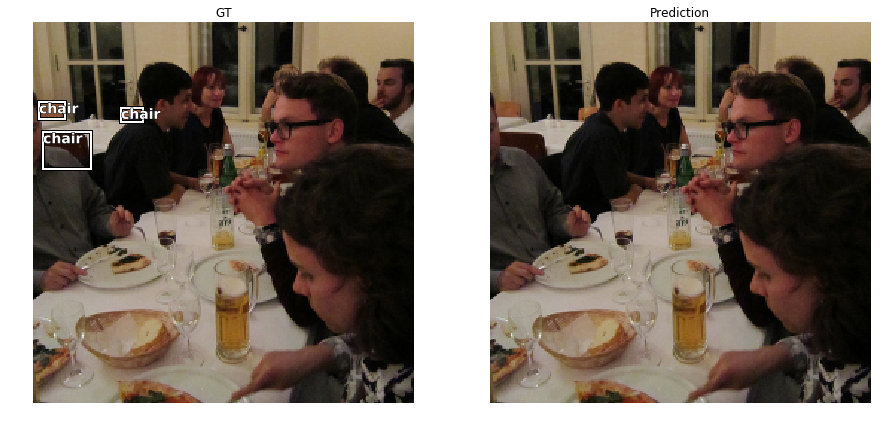

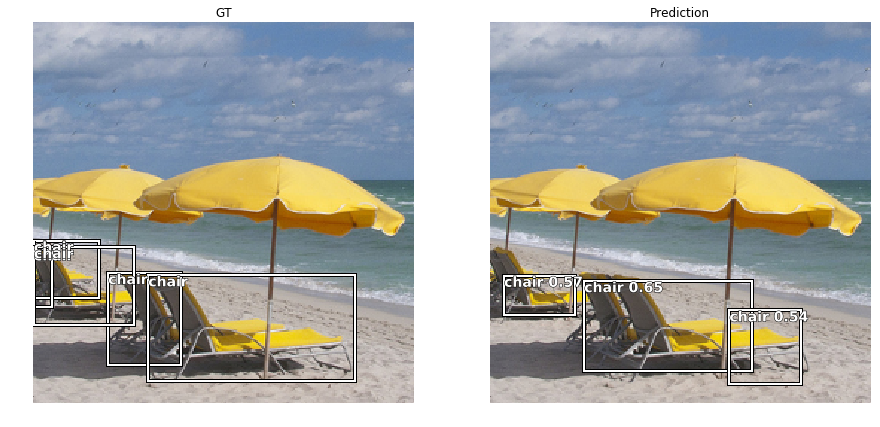

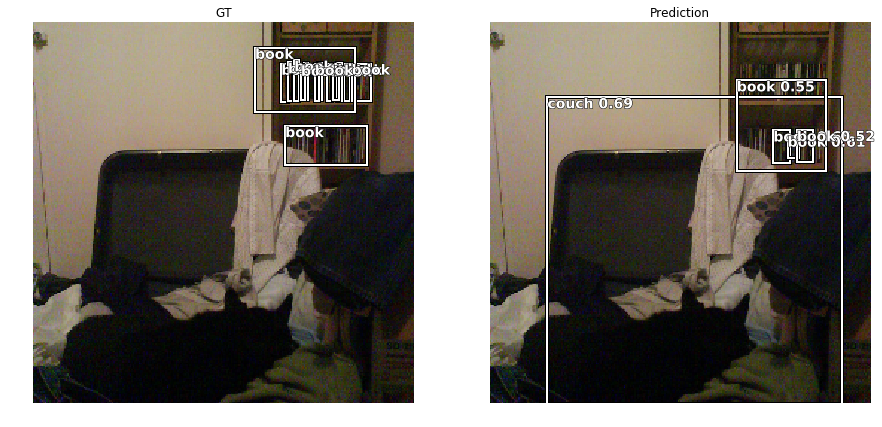

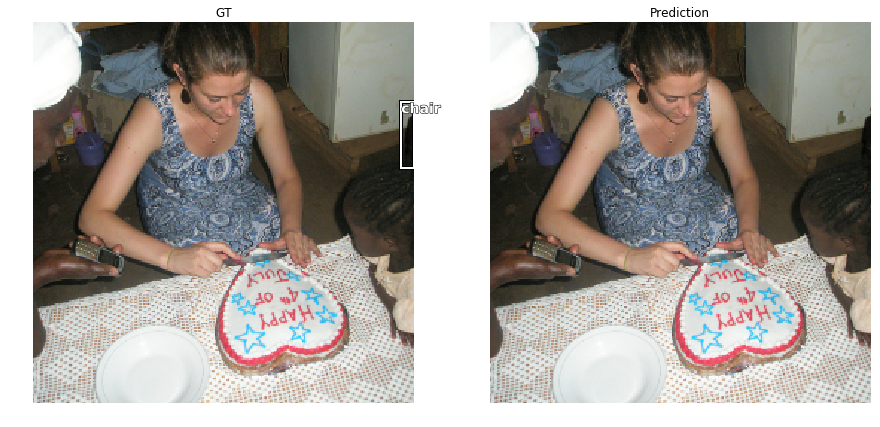

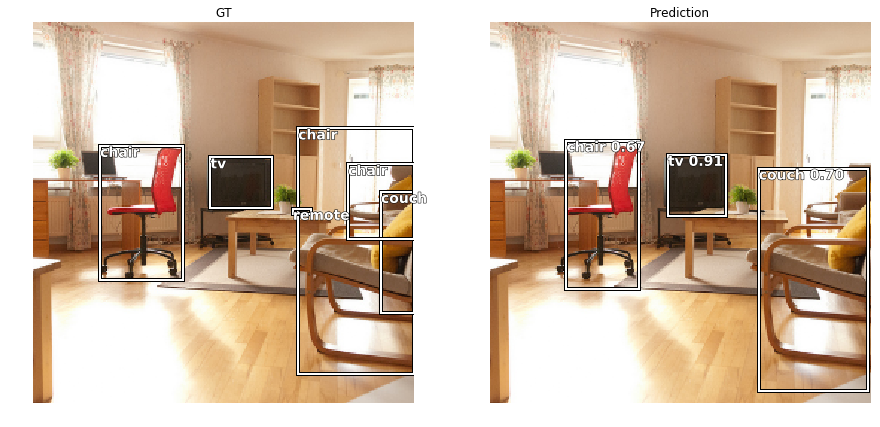

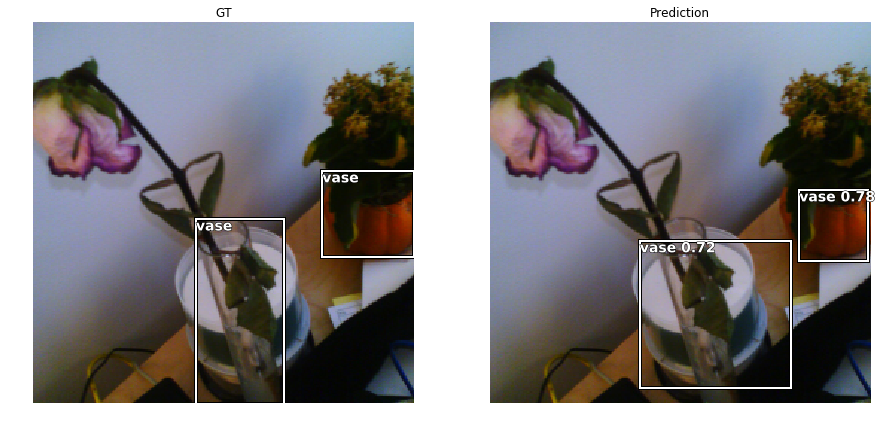

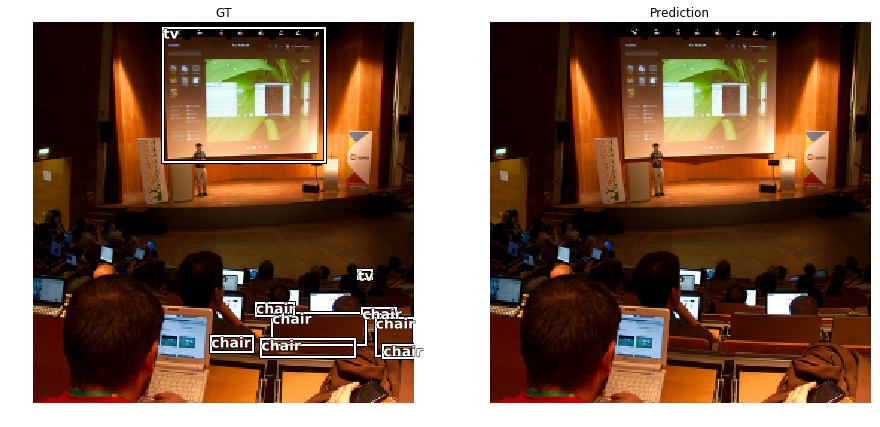

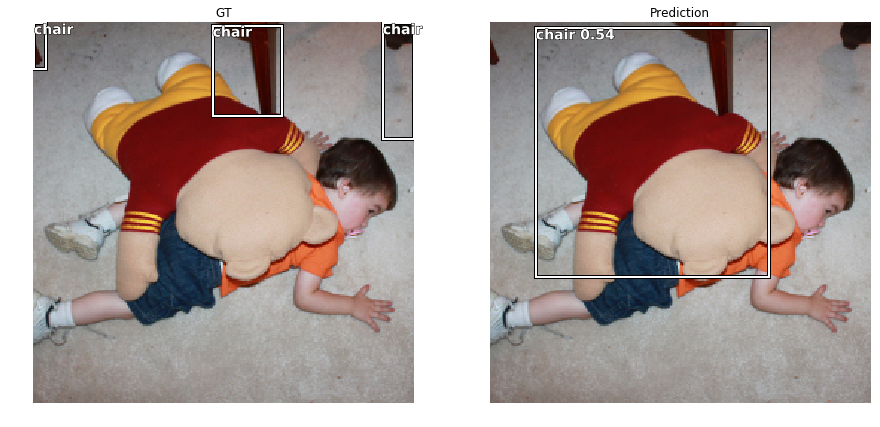

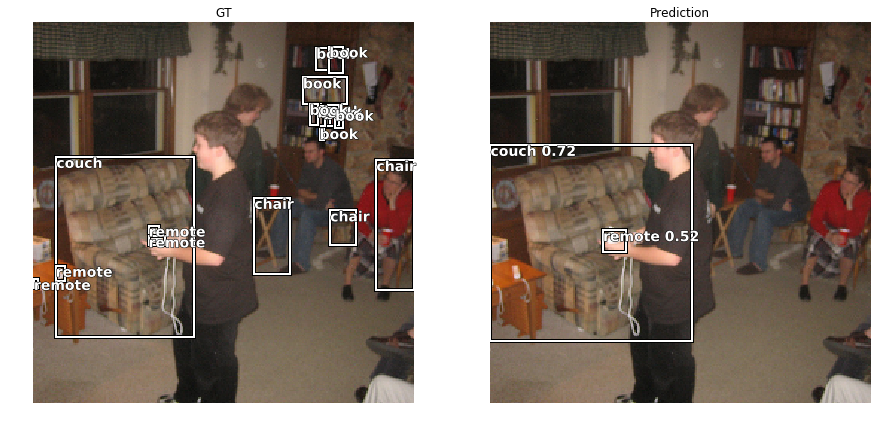

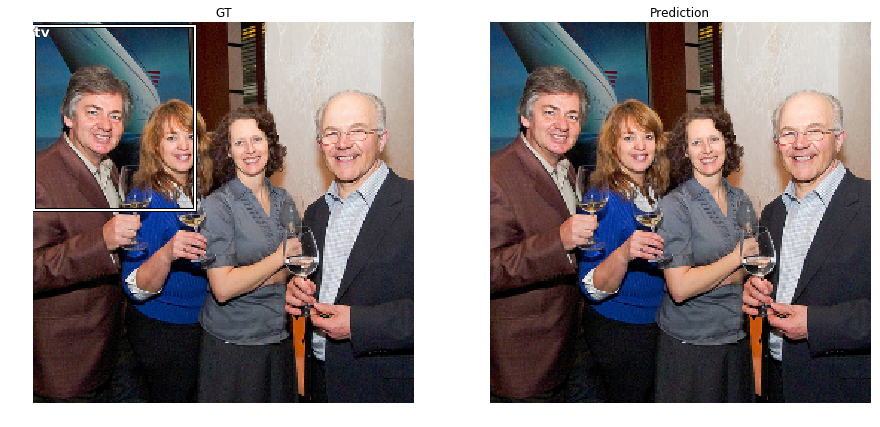

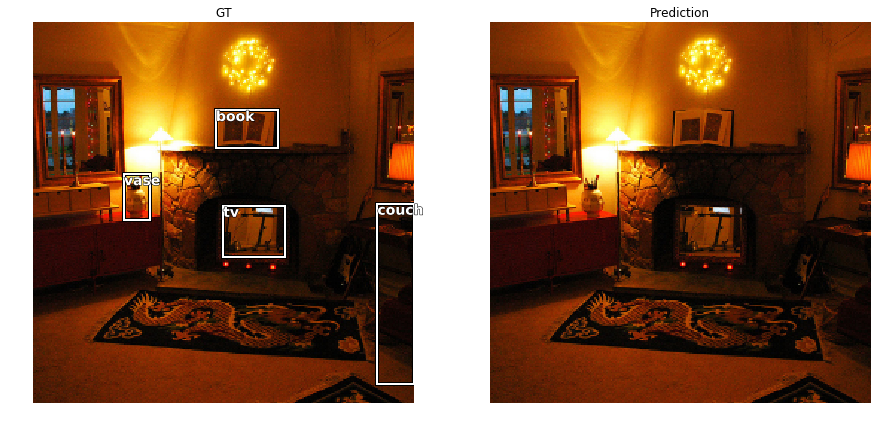

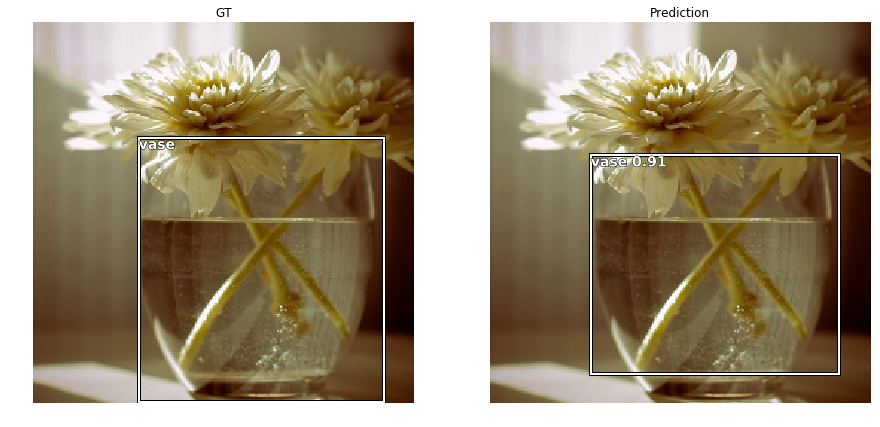

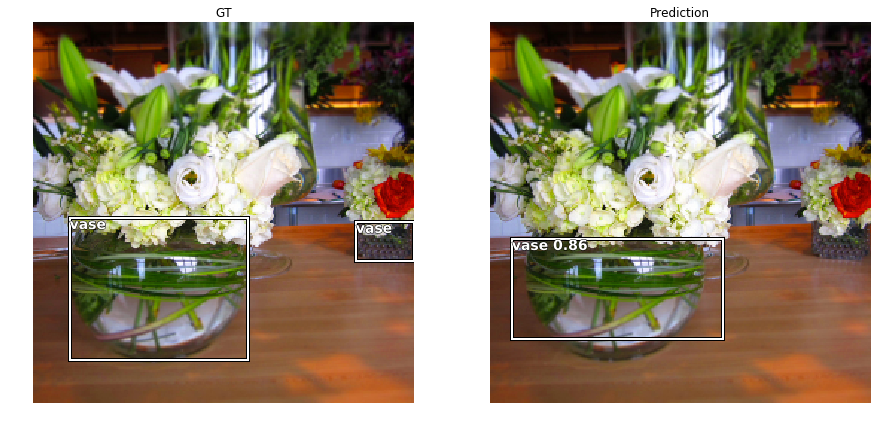

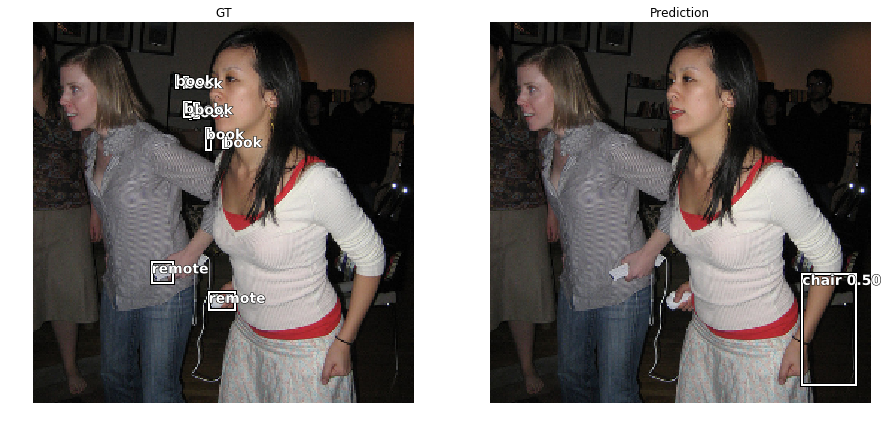

In [0]:
show_results_side_by_side(learn, anchors, detect_thresh=0.5, nms_thresh=0.1, image_count=25)